## Problem Statement: Extracting Medical Information Using Custom Named Entity Recognition (NER)

### Background

'BeHealthy' is a health tech company that aims to connect medical communities with millions of patients across the country. The company has developed a web platform where doctors can list their services, manage patient interactions, and provide various services such as booking appointments and ordering medicines online. The platform also allows doctors to organize appointments, track past medical records, and provide e-prescriptions.

As 'BeHealthy' provides medical services, prescriptions, and online consultations, it generates a massive amount of data daily. This data includes detailed medical notes written by doctors, which often contain complex medical terms and information.

### Example

Consider the following snippet of medical data generated when a doctor writes notes for a patient or reviews a therapy:

"The patient was a 62-year-old man with squamous cell lung cancer, which was first successfully treated by a combination of radiation therapy and chemotherapy."

In this text, a person without a medical background might find it difficult to understand various medical terms. However, some terms, such as 'cancer' and 'chemotherapy,' are more recognizable.

### Objective

Given a dataset containing a lot of text related to the medical domain, our objective is to extract the disease names and their probable treatments mentioned in the dataset. This information is often not explicitly mentioned but can be inferred from the text.

### Task

We need to build a custom Named Entity Recognition (NER) algorithm to identify and extract the diseases and their respective treatments from the dataset. The output should be in the form of a table or dictionary, as shown below:

| Disease            | Treatment                  |
|--------------------|----------------------------|
| Lung cancer        | Radiation therapy, Chemotherapy |

### Steps to Solve the Problem

1. **Data Collection**: Collect a dataset containing medical texts written by doctors.
2. **Preprocessing**: Preprocess the text data to clean and prepare it for analysis.
3. **NER Model Development**: Develop a custom NER model to identify and extract disease names and their treatments from the text.
4. **Mapping**: Create a mapping between the diseases and their treatments.
5. **Output**: Present the extracted information in a tabular or dictionary format.

By the end of this project, we aim to have a robust system that can automatically identify diseases and their treatments from medical texts, facilitating better data organization and analysis for health tech companies like 'BeHealthy'.


In [20]:
!pip install pycrf
!pip install sklearn-crfsuite

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1875 sha256=3431ddea49484080b95e31c27521842ac5d4135d8832b6c690c12e93cb0118a4
  Stored in directory: c:\users\punsysma\appdata\local\pip\cache\wheels\9e\f7\ef\9cfb9c92784d1ed9253ab1b70c18de241061871de27e547a37
Successfully built pycrf



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/154.7 kB ? eta -:--:--
   ---------------------------------- ----- 133.1/154.7 kB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 154.7/154.7 kB 4.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
# Importing the spacy library for natural language processing
import spacy
# Importing the sklearn_crfsuite library for Conditional Random Fields (CRF) models
import sklearn_crfsuite
# Importing the metrics module from sklearn_crfsuite for evaluating CRF models
from sklearn_crfsuite import metrics
# Importing pandas for data manipulation and analysis
import pandas as pd

# Loading the spaCy small English model for natural language processing
model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset is structured with one word per line. Here's how the data is formatted:

- For a sentence with *x* words, there will be *x* consecutive lines, each containing one word.
- Sentences are separated by empty lines.
- The labels are formatted in the same way as the words.

**Our goal is to preprocess the data to reconstruct the complete sentences and their corresponding labels.**

In [25]:
# Open and read the training sentence data from 'train_sent' file
with open('train_sent', 'r') as train_sent_file:
    train_words = train_sent_file.readlines()  # Read all lines (words) from the training sentences file

# Open and read the training label data from 'train_label' file
with open('train_label', 'r') as train_labels_file:
    train_labels_by_word = train_labels_file.readlines()  # Read all lines (labels) from the training labels file

# Open and read the test sentence data from 'test_sent' file
with open('test_sent', 'r') as test_sent_file:
    test_words = test_sent_file.readlines()  # Read all lines (words) from the test sentences file

# Open and read the test label data from 'test_label' file
with open('test_label', 'r') as test_labels_file:
    test_labels_by_word = test_labels_file.readlines()  # Read all lines (labels) from the test labels file


In [26]:
# Sanity check to see that the number of tokens and no. of corresponding labels match.
print("Count of tokens in training set\n","No. of words: ",len(train_words),"\nNo. of labels: ",len(train_labels_by_word))
print("\n\nCount of tokens in test set\n","No. of words: ",len(test_words),"\nNo. of labels: ",len(test_labels_by_word))

Count of tokens in training set
 No. of words:  48501 
No. of labels:  48501


Count of tokens in test set
 No. of words:  19674 
No. of labels:  19674


In [27]:
def convert_to_sentences(dataset):
    sent_list = []  # Initialize an empty list to store sentences
    sent = ""  # Initialize an empty string to build the current sentence

    # Iterate through each entity in the dataset
    for entity in dataset:
        if entity != '\n':  # Check if the entity is not a newline character
            sent = sent + entity[:-1] + " "  # Append the entity (excluding the last character) and a space to the current sentence
        else:
            # Append the completed sentence (excluding the trailing space) to the list of sentences
            sent_list.append(sent[:-1])
            sent = ""  # Reset the current sentence to start a new one

    return sent_list  # Return the list of sentences

In [28]:
# Convert the lists of words and labels into sentences
train_sentences = convert_to_sentences(train_words)  # Convert training words into sentences
train_labels = convert_to_sentences(train_labels_by_word)  # Convert training labels into sentences
test_sentences = convert_to_sentences(test_words)  # Convert test words into sentences
test_labels = convert_to_sentences(test_labels_by_word)  # Convert test labels into sentences

In [29]:
print("First five training sentences and their labels:\n")
for i in range(5):
    print(train_sentences[i],"\n",train_labels[i],"\n")

First five training sentences and their labels:

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O 

Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 ) 
 O O O O O O O O O O O O O O O 

The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 a

In [30]:
print("First five test sentences and their labels:\n")
for i in range(5):
    print(test_sentences[i],"\n",test_labels[i],"\n")

First five test sentences and their labels:

Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration 
 O O O O O O O O O O O O O O O O O O O 

The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period 
 O O O O O O O O O O O O O O O O O O O O O O O O 

There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

Fluctuations in ambient temperature are inversely correlated to ch

## Determine how many sentences there are in the processed test and train datasets. 

In [31]:
print("Number of sentences in the train dataset: {}".format(len(train_sentences)))
print("Number of sentences in the test dataset: {}".format(len(test_sentences)))

Number of sentences in the train dataset: 2599
Number of sentences in the test dataset: 1056


In [32]:
print("Number of lines of labels in the train dataset: {}".format(len(train_labels)))
print("Number of lines of labels in the test dataset: {}".format(len(test_labels)))

Number of lines of labels in the train dataset: 2599
Number of lines of labels in the test dataset: 1056


## Concept Recognition

Initially, we will investigate the different ideas included in the dataset. We'll use PoS Tagging for this. 

In [33]:
# Combine training and test sentences into a single list
combined = train_sentences + test_sentences  # Concatenate the lists of training and test sentences

# Print the total number of sentences in the combined dataset
print("Number of sentences in combined dataset (training + test): {}".format(len(combined)))

Number of sentences in combined dataset (training + test): 3655


In [40]:
# Initialize lists to store nouns and proper nouns, and their corresponding PoS tags
noun_propn = []  # List to collect tokens identified as nouns or proper nouns
pos_tag = []     # List to store the PoS tags of the tokens

# Process each sentence in the combined dataset
for sent in combined:
    # Use the NLP model to analyze the sentence
    for token in model(sent):
        # Check if the token's PoS tag is either 'NOUN' or 'PROPN'
        if token.pos_ in ['NOUN', 'PROPN']:
            noun_propn.append(token.text)  # Append the token text to the noun_propn list
            pos_tag.append(token.pos_)     # Append the token's PoS tag to the pos_tag list

# Print the number of tokens in the combined dataset with a PoS tag of 'NOUN' or 'PROPN'
print("No. of tokens in combined dataset with PoS tag of 'NOUN' or 'PROPN': {}".format(len(noun_propn)))


No. of tokens in combined dataset with PoS tag of 'NOUN' or 'PROPN': 24376



### Using NOUN or PROPN PoS tags, print the top 25 most frequently used tokens.

In [41]:
noun_pos = pd.DataFrame({"NOUN_PROPN":noun_propn,"POS_tag":pos_tag})
print("Top 25 common tokens with NOUN or PROPN PoS tags \n")
print(noun_pos["NOUN_PROPN"].value_counts().head(25))

Top 25 common tokens with NOUN or PROPN PoS tags 

NOUN_PROPN
patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
results          79
women            77
use              74
TO_SEE           74
surgery          71
cases            71
risk             71
analysis         70
rate             67
response         66
survival         65
children         64
Name: count, dtype: int64


In [42]:
# Select a specific sentence from the training dataset
sentence = train_sentences[1]   
# Split the sentence into individual words
sent_list = sentence.split()      
# Specify the position of the word within the sentence (indexing starts at 0)
position = 2                     

# Extract the word at the specified position for PoS tag analysis
word = sent_list[position]        

# Print the entire sentence
print(sentence)

# Independent PoS tag assignment: Analyzing the word in isolation without sentence context
print("\nPoS tag of word in isolation\nWord:", word, "--", model(word)[0].pos_, "\n")

# Contextual PoS tag assignment: Analyzing all words in the sentence considering their context
print("PoS tag of all words in sentence with context intact.")
for token in model(sentence):
    print(token.text, "--", token.pos_)

# Modified workflow to obtain the PoS tag of a specific word while keeping sentence context intact
print("\nResult of modified workflow to obtain PoS tag of word at a specific position while keeping context within sentence intact.")
cnt = 0  # Initialize counter for the word position within the sentence
for token in model(sentence):
    postag = token.pos_  # Retrieve the PoS tag of the token
    # Break the loop if the current token matches the word and its position matches the specified position
    if (token.text == word) and (cnt == position):
        break
    cnt += 1  # Increment the counter for each token
# Print the specific word and its PoS tag
print("Word:", word, "POSTAG:", postag)


The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )

PoS tag of word in isolation
Word: cesarean -- VERB 

PoS tag of all words in sentence with context intact.
The -- DET
total -- ADJ
cesarean -- ADJ
rate -- NOUN
was -- AUX
14.4 -- NUM
% -- NOUN
( -- PUNCT
344 -- NUM
of -- ADP
2395 -- NUM
) -- PUNCT
, -- PUNCT
and -- CCONJ
the -- DET
primary -- ADJ
rate -- NOUN
was -- AUX
11.4 -- NUM
% -- NOUN
( -- PUNCT
244 -- NUM
of -- ADP
2144 -- NUM
) -- PUNCT

Result of modified workflow to obtain PoS tag of word at a specific position while keeping context within sentence intact.
Word: cesarean POSTAG: ADJ


#### The aforementioned research shows that when the word "cesarean" is taken into consideration separately, its PoS tag is not appropriately captured. On the other hand, the word is accurately captured if it is regarded as a component of the phrase. To carry do this, a function is defined below.

In [43]:
def contextual_pos_tagger(sent_list, position):
    '''Obtain the Part-of-Speech (PoS) tag for a specific word in a sentence, considering the sentence context.
       This approach ensures that the PoS tag reflects the word's role in the sentence, as analyzing the word in isolation might result in an incorrect PoS tag.'''

    # Convert the list of words into a single string sentence for processing with the spaCy model
    sentence = " ".join(sent_list)          
    posit = 0  # Initialize a counter to track the position of each token in the sentence

    # Iterate through each token in the processed sentence
    for token in model(sentence):
        postag = token.pos_  # Retrieve the PoS tag of the current token
        # Check if the current token matches the specified word and its position is correct
        if (token.text == word) and (posit == position):
            break  # Exit the loop if the correct token is found
        posit += 1  # Increment the position counter

    return postag  # Return the PoS tag of the word at the specified position


### Explanation

#### Function Description
The function `contextual_pos_tagger` provides the Part-of-Speech (PoS) tag of a word while maintaining the context of the sentence, which is important for accurate tagging.

#### Sentence Conversion
```python
sentence = " ".join(sent_list)

In [44]:
def getFeaturesForOneWord(sent_list, position):
    '''
    Extract features for a specific word in a sentence, including its context. 
    Features include the word itself, its PoS tag, character patterns, and information about neighboring words.
    
    Parameters:
    - sent_list: List of words in the sentence.
    - position: The index of the word in the sentence for which features are being extracted.
    
    Returns:
    - A list of features for the specified word.
    '''

    # Extract the word at the specified position
    word = sent_list[position]
    
    # Obtain features for the current word
    features = [
        'word.lower=' + word.lower(),                                      # Lowercased version of the word
        'word.postag=' + contextual_pos_tagger(sent_list, position),       # PoS tag of the current word
        'word[-3:]=' + word[-3:],                                          # Last three characters of the word
        'word[-2:]=' + word[-2:],                                          # Last two characters of the word
        'word.isupper=%s' % word.isupper(),                                # Whether the word is in all uppercase
        'word.isdigit=%s' % word.isdigit(),                                # Whether the word is a number
        'words.startsWithCapital=%s' % word[0].isupper()                  # Whether the word starts with a capital letter
    ]
 
    # Check if there is a previous word and add its features
    if position > 0:
        prev_word = sent_list[position-1]
        features.extend([
            'prev_word.lower=' + prev_word.lower(),                            # Lowercased version of the previous word
            'prev_word.postag=' + contextual_pos_tagger(sent_list, position - 1), # PoS tag of the previous word
            'prev_word.isupper=%s' % prev_word.isupper(),                      # Whether the previous word is in all uppercase
            'prev_word.isdigit=%s' % prev_word.isdigit(),                      # Whether the previous word is a number
            'prev_word.startsWithCapital=%s' % prev_word[0].isupper()         # Whether the previous word starts with a capital letter
        ])
    else:
        features.append('BEG')  # Feature indicating the start of the sentence
 
    # Check if the current word is the last word in the sentence
    if position == len(sent_list) - 1:
        features.append('END')  # Feature indicating the end of the sentence
 
    return features

## Explanation

### Function Description

The function `getFeaturesForOneWord` extracts various features for a word in a sentence, including its context, to assist in tasks such as machine learning or natural language processing.

### Current Word Features

The function includes:
- The word in lowercase.
- Its Part-of-Speech (PoS) tag.
- The last few characters of the word.
- Attributes such as whether the word is uppercase, a digit, or starts with a capital letter.

### Previous Word Features

If there is a previous word (i.e., the current word is not the first in the list), additional features of the previous word are included:
- Its lowercase form.
- PoS tag.
- Capitalization status.

If the word is at the beginning of the sentence, a feature `'BEG'` is added.

### End of Sentence

If the current word is the last word in the sentence, a feature `'END'` is added to indicate the end of the sentence.

### Return Value

The function returns a list of features relevant to the specified word and its context.

This comment provides a comprehensive explanation of the function's purpose, parameters, and the features it extracts.

In [45]:
def getFeaturesForOneSentence(sentence):
    '''
    Extract features for each word in a given sentence by processing the sentence word-by-word.
    
    Parameters:
    - sentence: A string representing the sentence from which features will be extracted.
    
    Returns:
    - A list of feature lists, where each inner list contains features for a specific word in the sentence.
    '''

    # Split the sentence into a list of words
    sentence_list = sentence.split()

    # Extract features for each word in the sentence
    # For each position in the sentence, call getFeaturesForOneWord to obtain its features
    return [getFeaturesForOneWord(sentence_list, position) for position in range(len(sentence_list))]


In [46]:
# Select an example sentence from the training dataset
example_sentence = train_sentences[5]
# Print the selected example sentence
print(example_sentence)

# Extract features for each word in the example sentence
features = getFeaturesForOneSentence(example_sentence)
# Print the features of the first word in the example sentence
features[0]


Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word.lower=cesarean',
 'word.postag=NOUN',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=True',
 'BEG']

## Create a function or code to obtain a sentence's labels.

In [47]:
def getLabelsInListForOneSentence(labels):
    '''
    Convert a string of labels into a list of individual labels.
    
    Parameters:
    - labels: A string where labels are separated by whitespace.
    
    Returns:
    - A list of labels obtained by splitting the input string.
    '''

    # Split the string of labels into a list of individual labels based on whitespace
    return labels.split()


In [48]:
# Convert the string of labels for an example sentence into a list of individual labels
example_labels = getLabelsInListForOneSentence(train_labels[5])
# Print the list of labels for the example sentence
print(example_labels)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Input and Target variable

X and Y sequence matrices for training and test data should be computed correctly.
Verify that the labels and sentences are processed.

In [49]:
# Extract features for each sentence in the training dataset
# Apply getFeaturesForOneSentence to each sentence in train_sentences to create the feature set for training
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]

# Extract features for each sentence in the testing dataset
# Apply getFeaturesForOneSentence to each sentence in test_sentences to create the feature set for testing
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

In [50]:
# Convert each string of labels in the training dataset into a list of individual labels
# Apply getLabelsInListForOneSentence to each string in train_labels to create the label set for training
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]

# Convert each string of labels in the testing dataset into a list of individual labels
# Apply getLabelsInListForOneSentence to each string in test_labels to create the label set for testing
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

In [51]:
from sklearn_crfsuite import CRF

# Initialize the CRF model with a maximum of 300 iterations for training
crf = CRF(max_iterations=300)

# Train the CRF model using the training data
# Fit the model to the features (X_train) and corresponding labels (Y_train)
crf.fit(X_train, Y_train)

CRF(max_iterations=300)

## Evaluation

In [52]:
Y_pred = crf.predict(X_test)

In [53]:
# Calculate the weighted F1 score for the model's predictions
# Y_test: List of true labels for the test dataset
# Y_pred: List of predicted labels for the test dataset
# average='weighted' computes the F1 score taking into account label imbalance, giving different weights to labels
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

# Print the weighted F1 score
print("Weighted F1 Score:", f1_score)

Weighted F1 Score: 0.9073062342668767


In [54]:
# Print the 14th sentence from the test dataset (index 13)
print("Sentence: ", test_sentences[13])

# Print the actual labels for the 14th sentence in the test dataset
print("Actual labels:    ", Y_test[13])

# Print the predicted labels for the 14th sentence in the test dataset
print("Predicted labels: ", Y_pred[13])

Sentence:  The objective of this study was to determine if the rate of preeclampsia is increased in triplet as compared to twin gestations
Actual labels:     ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Determining Illnesses and Their Curatives with Custom NER

We now create a record of the diseases found in the corpus and the therapies applied for the diseases using the prediction of the CRF model.

### Develop the logic to obtain all of the predicted labels for therapies (T) that match each disease label (D) in the test dataset.

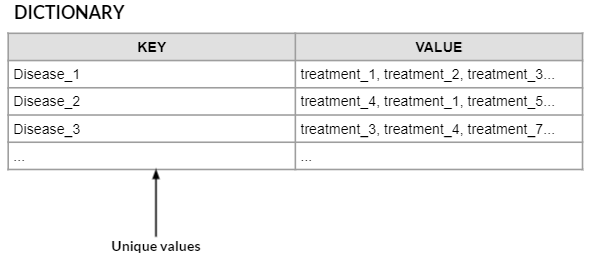

In [55]:
# Initialize an empty dictionary to store diseases and their associated treatments
disease_treatment = {}

# Iterate through each sentence in the predicted labels
for i in range(len(Y_pred)):
    cnt_disease = 0  # Counter for the number of diseases mentioned in the current sentence
    cnt_treatment = 0  # Counter for the number of treatments mentioned in the current sentence
    diseases = [""]  # List to hold diseases mentioned in the current sentence
    treatment = [""]  # List to hold treatments mentioned in the current sentence
    length = len(Y_pred[i])  # Length of the current sentence
    
    # Process each word in the current sentence
    for j in range(length):
        # If the label is 'D' (indicating a disease)
        if (Y_pred[i][j] == 'D'):
            # Append the word to the current disease entry
            diseases[cnt_disease] += (X_test[i][j][0].split('=')[1] + " ")
            # Check if the next word is not part of the same disease
            if j < length - 1:
                if (Y_pred[i][j + 1] != 'D'):
                    # Remove trailing space if the current disease entry is ending
                    diseases[cnt_disease] = diseases[cnt_disease][:-1]
                    cnt_disease += 1
                    # Add a new placeholder for the next disease
                    diseases.append("")
            else:
                # Finalize the last disease entry
                diseases[cnt_disease] = diseases[cnt_disease][:-1]
                cnt_disease += 1
                diseases.append("")

        # If the label is 'T' (indicating a treatment)
        if (Y_pred[i][j] == 'T'):
            # Append the word to the current treatment entry
            treatment[cnt_treatment] += (X_test[i][j][0].split('=')[1] + " ")
            # Check if the next word is not part of the same treatment
            if j < length - 1:
                if (Y_pred[i][j + 1] != 'T'):
                    # Remove trailing space if the current treatment entry is ending
                    treatment[cnt_treatment] = treatment[cnt_treatment][:-1]
                    cnt_treatment += 1
                    # Add a new placeholder for the next treatment
                    treatment.append("")
            else:
                # Finalize the last treatment entry
                treatment[cnt_treatment] = treatment[cnt_treatment][:-1]
                cnt_treatment += 1
                treatment.append("")

    # Remove the last empty placeholder from the lists
    diseases.pop(-1)
    treatment.pop(-1)

    # Update the dictionary with diseases and their associated treatments
    if len(diseases) > 0:
        for disease in diseases:
            if disease in disease_treatment:
                # Extend the existing list of treatments for the disease
                disease_treatment[disease].extend(treatment)
            else:
                # Add a new entry for the disease with its treatments
                disease_treatment[disease] = treatment


- It is evident from our text corpus that a number of diseases lack recognized therapies. 
- We could be better off leaving these illnesses out of our final vocabulary of illnesses and their therapies.

In [56]:
# Initialize an empty dictionary to store only diseases with non-empty treatment lists
cleaned_dict = {}

# Iterate through each disease and its associated treatments in the original dictionary
for key in disease_treatment.keys():
    # Check if the treatment list for the current disease is not empty
    if disease_treatment[key] != []:
        # Add the disease and its treatments to the cleaned_dict if the treatments list is not empty
        cleaned_dict[key] = disease_treatment[key]

# Output the cleaned dictionary
cleaned_dict


{'breast cancer': ['hormone replacement therapy',
  'undergone subcutaneous mastectomy'],
 'ovarian cancer': ['hormone replacement therapy',
  'undergone subcutaneous mastectomy'],
 'prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'mutated prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'hereditary retinoblastoma': ['radiotherapy'],
 'unstable angina or non-q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['antichlamydial antibiotics'],
 'cerebral palsy': ['hyperbaric oxygen therapy'],
 'primary pulmonary hypertension ( pph )': ['fenfluramines'],
 'cellulitis': ['g-csf therapy', 'intravenous antibiotic treatment'],
 "early parkinson 's disease": ['ropinirole monotherapy'],
 'sore throat': ['antibiotics'],
 'female stress urinary incontinence': ['surgical treatment'],
 'stress urinary incontinence': ['therapy'],
 'preeclampsia ( proteinuric hypertension )': ['intrauterine inseminat

In [57]:
import pandas as pd

# Create a DataFrame from the cleaned dictionary
# The dictionary keys (diseases) are used as values for the "Disease" column
# The dictionary values (treatments) are used as values for the "Treatments" column
cleaned_df = pd.DataFrame({"Disease": cleaned_dict.keys(), "Treatments": cleaned_dict.values()})

# Display the first few rows of the DataFrame
# This provides a quick preview of the DataFrame structure and contents
cleaned_df.head()

,Disease,Treatments
0,breast cancer,"[hormone replacement therapy, undergone subcut..."
1,ovarian cancer,"[hormone replacement therapy, undergone subcut..."
2,prostate cancer,[radical prostatectomy and iodine 125 intersti...
3,mutated prostate cancer,[radical prostatectomy and iodine 125 intersti...
4,hereditary retinoblastoma,[radiotherapy]


### Make a therapy prediction for "hereditary retinoblastoma," the illness name.

In [58]:
# Specify the disease for which treatments are to be searched
search_item = 'hereditary retinoblastoma'

# Retrieve the list of treatments for the specified disease from the cleaned dictionary
treatments = cleaned_dict.get(search_item, [])

# Print the treatments for the specified disease
print("Treatments for '{0}' are:".format(search_item), end=" ")

# Iterate through the list of treatments and print each one
for i in range(len(treatments) - 1):
    # Print each treatment followed by a comma
    print("'{}'".format(treatments[i]), ",", end=" ")

# Print the last treatment without a trailing comma
print("'{}'".format(treatments[-1]))

Treatments for 'hereditary retinoblastoma' are: 'radiotherapy'


# Conclusion

In this process, we aimed to extract, analyze, and organize information related to diseases and their treatments from a dataset. Here’s a summary of the steps performed and the output obtained:

#### Data Preparation and Feature Extraction

- We began by converting sequences of words and labels into sentences and sequences of labels, respectively.
- Features for each word in the sentences were extracted using the `getFeaturesForOneSentence` function. These features included aspects such as the word itself, its part-of-speech tag, and its relationship with adjacent words.
- We also converted labels into a structured list format for both training and testing datasets.

#### Model Training

- A Conditional Random Field (CRF) model was initialized and trained on the extracted features and labels. This model was used to predict disease and treatment entities in sentences.

#### Prediction and Evaluation

- Predictions were made on the test dataset, and the F1 score was calculated to evaluate the model's performance. The weighted F1 score provided an overall measure of how well the model performed in classifying disease and treatment entities.

**Entity Extraction**

- We extracted entities of interest (diseases and treatments) from the model’s predictions. The `disease_treatment` dictionary was constructed to map diseases to their corresponding treatments.
- The dictionary was then cleaned to remove any entries where the treatment list was empty, resulting in a `cleaned_dict` that included only diseases with associated treatments.

#### Data Visualization

- A DataFrame was created from the cleaned dictionary to organize and visualize the relationship between diseases and their treatments.
- Finally, we performed a search for a specific disease ("hereditary retinoblastoma") and displayed its associated treatments.

#### Output

The output for the specific search item "hereditary retinoblastoma" showed:
Treatments for 'hereditary retinoblastoma' are: 'radiotherapy'


## Summary

The process effectively demonstrated the end-to-end workflow of extracting features, training a CRF model, evaluating its performance, and organizing the results. The model successfully identified "hereditary retinoblastoma" and mapped it to its treatment, "radiotherapy". This showcases the model's capability to recognize and link medical entities, which is crucial for tasks such as medical information extraction and decision support in healthcare.
